# Test tf.keras with eager execution

Can I debug line-by-line?

https://www.tensorflow.org/guide/eager

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
from cbrain.utils import limit_mem
from cbrain.imports import *
from cbrain.data_generator import *

/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
limit_mem()

In [4]:
tf.__version__

'1.8.0'

In [5]:
tf.executing_eagerly() 

True

## A very simple example

### Build a tf.keras model

In [5]:
model = tf.contrib.keras.models.Sequential([
  tf.contrib.keras.layers.Dense(20, input_shape=(784,)),  # must declare input shape
  tf.contrib.keras.layers.Dense(10)
])

In [6]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.contrib.keras.datasets.mnist.load_data()

In [7]:
mnist_images.shape, mnist_labels.shape

((60000, 28, 28), (60000,))

In [8]:
x = mnist_images

In [9]:
model(mnist_images[0].flatten()[None,:])

<tf.Tensor: id=56, shape=(1, 10), dtype=float32, numpy=
array([[ 285.0013   ,  141.86801  ,  175.94553  , -314.51416  ,
         -37.734264 ,  -93.59766  ,   -5.1242294, -168.7581   ,
          84.35063  ,  173.94041  ]], dtype=float32)>

In [10]:
l = model.layers

In [11]:
l[0](mnist_images[0].flatten()[None,:])

<tf.Tensor: id=62, shape=(1, 20), dtype=float32, numpy=
array([[ -31.167633 ,  -73.135574 , -269.93137  , -197.12778  ,
         -57.28427  ,   58.116283 ,   33.642563 ,  203.31308  ,
         171.42195  ,   69.82724  , -331.0267   , -194.39763  ,
         -18.159151 ,  -96.43982  , -158.83148  , -346.0164   ,
         166.2456   ,  134.84703  , -115.31598  ,    1.1098976]],
      dtype=float32)>

In [12]:
model.compile(tf.train.AdamOptimizer(0.01), 'sparse_categorical_crossentropy')   # This is obvously not right

In [13]:
model.fit(mnist_images.reshape(-1, 28*28), mnist_labels)

Epoch 1/1
60000/60000 [==============================] - 12s 197us/step - loss: 10.7298


## Test for status-quo CBRAIN workflow

In [6]:
DATADIR = '/local/S.Rasp/preprocessed_data/'

In [7]:
!ls $DATADIR

32_col_engy_ess_1y_train_features.nc
32_col_engy_ess_1y_train_shuffle_features.nc
32_col_engy_ess_1y_train_shuffle_targets.nc
32_col_engy_ess_1y_train_targets.nc
32_col_engy_ess_3d_train_features.nc
32_col_engy_ess_3d_train_norm.nc
32_col_engy_ess_3d_train_shuffle_features.nc
32_col_engy_ess_3d_train_shuffle_targets.nc
32_col_engy_ess_3d_train_targets.nc
32_col_engy_ess_3d_valid_features.nc
32_col_engy_ess_3d_valid_targets.nc
32_col_mp_3d_train_features.nc
32_col_mp_3d_train_norm.nc
32_col_mp_3d_train_targets.nc
fbp_engy_ess_ref_train_fullyear_shuffle_features.nc
fbp_engy_ess_ref_train_fullyear_shuffle_targets.nc
fbp_engy_ess_ref_train_sample1_norm_big_fluxes2.nc
fbp_engy_ess_ref_train_sample1_norm_big_fluxes.nc
fbp_engy_ess_ref_train_sample1_norm.nc
fbp_engy_ess_ref_train_sample1_norm_small_fluxes2.nc
fbp_engy_ess_ref_train_sample1_norm_small_fluxes.nc
fbp_engy_ess_train_fullyear_norm.nc
fbp_engy_ess_train_sample1_norm.nc
fbp_engy_ess_valid_fullyear_features.nc
fbp_engy_ess_valid_full

In [8]:
train_gen = DataGenerator(
    data_dir=DATADIR, 
    feature_fn='32_col_engy_ess_3d_train_shuffle_features.nc',
    target_fn='32_col_engy_ess_3d_train_shuffle_targets.nc',
    batch_size=512,
    norm_fn='32_col_engy_ess_3d_train_norm.nc',
    fsub='feature_means', 
    fdiv='feature_stds', 
    tmult='target_conv',
    shuffle=True,
)

Generator will have 14057472 samples in 27456 batches
Features have shape 94; targets have shape 65


In [9]:
gen = train_gen.return_generator()

In [10]:
x, y = next(gen)

In [11]:
x.shape, y.shape

((512, 94), (512, 65))

In [12]:
import pdb

In [13]:
class TestLayer(tf.contrib.keras.layers.Layer):   # Important to not use keras.layers.Layer
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, x):
        #pdb.set_trace()
        x1 = x[:, :30]
        x2 = x[:, 30:]
        
        x1 *= 1000.
        
        out = tf.concat([x1, x2], 1)
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [14]:
inp = tf.contrib.keras.layers.Input(shape=(94,))
act = tf.contrib.keras.layers.Dense(256, activation='relu')(inp)
for i in range(4):
    act = tf.contrib.keras.layers.Dense(256, activation='relu')(act)
act = tf.contrib.keras.layers.Dense(65, activation='relu')(act)
out = TestLayer()(act)
m = tf.contrib.keras.models.Model(inputs=inp, outputs=out)

In [15]:
m.layers

In [16]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 94)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               24320     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 65)                16705     
__________

In [17]:
preds = m(x)

In [18]:
preds.numpy().shape

(512, 65)

It all seems to work as I hoped. Basically like using PyTorch with the simple Keras API! Awesome.

## Test a custom training loop

In [19]:
train_gen.n_batches

27456

In [20]:
optimizer = tf.train.AdamOptimizer()

In [21]:
from tqdm import tqdm_notebook as tqdm

In [22]:
loss_hist = []

for i in tqdm(range(train_gen.n_batches)):
    x, y = next(gen)
    with tf.GradientTape() as tape:   # This is where tf gets ugly
        preds = m(x)
        loss = tf.losses.mean_squared_error(y, preds)
    
    loss_hist.append(loss)
    grads = tape.gradient(loss, m.variables)
    optimizer.apply_gradients(zip(grads, m.variables))
    
        

KeyboardInterrupt: 

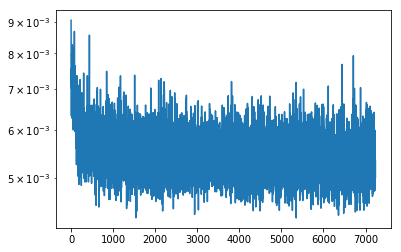

In [29]:
plt.plot(loss_hist[10:])
plt.yscale('log')

### Profiling

In [32]:
def loop(n_batches):
    for i in tqdm(range(n_batches)):
        x, y = next(gen)
        with tf.GradientTape() as tape:   # This is where tf gets ugly
            preds = m(x)
            loss = tf.losses.mean_squared_error(y, preds)

        loss_hist.append(loss)
        grads = tape.gradient(loss, m.variables)
        optimizer.apply_gradients(zip(grads, m.variables))

In [34]:
%load_ext line_profiler

In [35]:
%lprun -f loop loop(500)

Profiling also works great which will really help later on. There are performance issues which we will have to sort out going on.